In [5]:
import pandas as pd
import matplotlib.pyplot as plt 

I read some where that data is beautiful, let me show you how data is beautiful!! My signature statement, something I called plot language. 


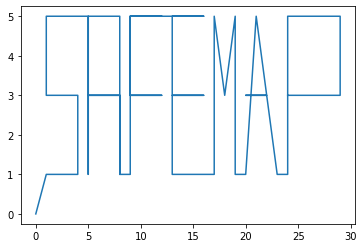

In [6]:
x=[0,1,2,3,4,4,4,3,2,1,1,1,2,3,4,5,5,5,5,5,5,7,8,8,8,8,8,8,8,7,6,5,6,7,8,8,8,9,9,9,9,9,10,11,12,9,9,12,9,9,16,13,13,16,13,13,16,17,17,18,19,19,20,21,22,20,22,23,24,24,29,29,24]
y=[0,1,1,1,1,2,3,3,3,3,4,5,5,5,5,5,1,2,3,4,5,5,5,4,3,2,1,2,3,3,3,3,3,3,3,2,1,1,2,3,4,5,5,5,5,5,3,3,3,5,5,5,3,3,3,1,1,1,5,3,5,1,1,5,3,3,3,1,1,5,5,3,3]

plt.plot(x, y)

Let's read data.

In [7]:
df=pd.read_excel("C:/Users/sachinksingh/Documents/{{My Documents}}/SachinUV/Inspiring/UltraMap/routeData.xlsx")
df.head()

,AnonymousSources(MultipleNumbers),Date,LocationName,LocationFrom,LocationTo,AvgEstimatedArrivalInBeginning(mins),AvgActualArrivalTime(mins),RouteChanged,AlterRouteCords,MergedRouteCords
0,1,2020-10-27,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",40,42,No,NaN,NaN
1,2,2020-10-28,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",41,43,No,NaN,NaN
2,3,2020-10-29,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",42,44,No,NaN,NaN
3,4,2020-10-30,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",43,45,No,NaN,NaN
4,5,2020-10-31,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",44,46,No,NaN,NaN


Now lets try to find out Anomaly.

In [8]:
location_route_df = df[['AnonymousSources(MultipleNumbers)','RouteChanged']]
location_route_df.head()

,AnonymousSources(MultipleNumbers),RouteChanged
0,1,No
1,2,No
2,3,No
3,4,No
4,5,No


In [9]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in location_route_df.iterrows():
    c = Counter(row['RouteChanged'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

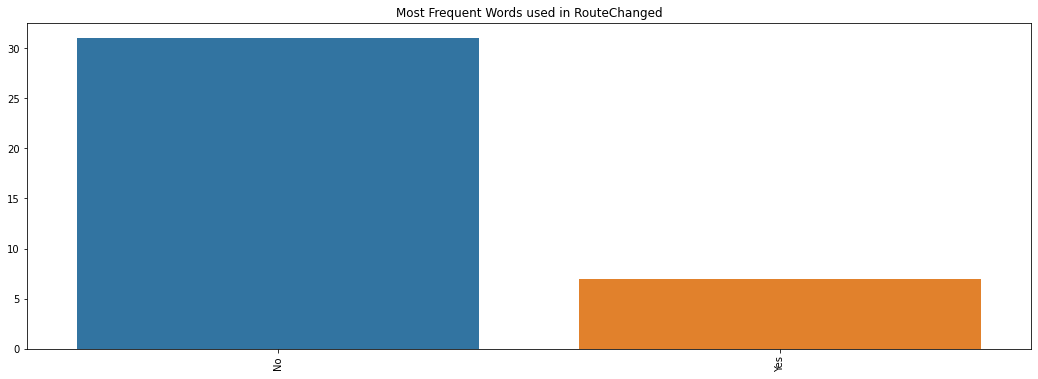

In [11]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in RouteChanged')

In [12]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]    

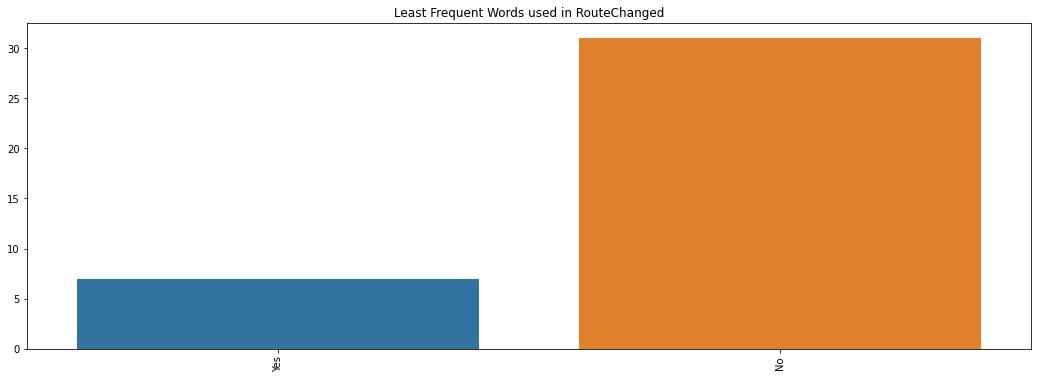

In [13]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in RouteChanged')

In [14]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['RouteChanged']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['RouteChanged']).split())
                                     for index, row in df_x.iterrows()]))
    


In [15]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(location_route_df)
doc2vec_vectors = doc2vec_tr.transform(location_route_df)

100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 37921.38it/s]


In [16]:
print(doc2vec_vectors)

[[-8.1528252e-04  1.1242923e-03  6.1931083e-04 ... -1.0569408e-03
  -9.8026625e-04  3.6491663e-04]
 [-8.1528252e-04  1.1242923e-03  6.1931083e-04 ... -1.0569408e-03
  -9.8026625e-04  3.6491663e-04]
 [-8.1528252e-04  1.1242923e-03  6.1931083e-04 ... -1.0569408e-03
  -9.8026625e-04  3.6491663e-04]
 ...
 [ 1.0923506e-03 -5.2470896e-05  7.8268931e-04 ... -1.0431057e-03
   1.3853995e-03  1.3210188e-03]
 [ 1.0923506e-03 -5.2470896e-05  7.8268931e-04 ... -1.0431057e-03
   1.3853995e-03  1.3210188e-03]
 [ 1.0923506e-03 -5.2470896e-05  7.8268931e-04 ... -1.0431057e-03
   1.3853995e-03  1.3210188e-03]]


In [17]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [18]:
print(predicted_vectors)

[[ 0.00444774  0.01104856  0.00343024 ... -0.00454864  0.00010467
  -0.00118758]
 [ 0.00444774  0.01104856  0.00343024 ... -0.00454864  0.00010467
  -0.00118758]
 [ 0.00444774  0.01104856  0.00343024 ... -0.00454864  0.00010467
  -0.00118758]
 ...
 [ 0.0042293   0.01125389  0.0033826  ... -0.00390734 -0.00045956
  -0.00123933]
 [ 0.0042293   0.01125389  0.0033826  ... -0.00390734 -0.00045956
  -0.00123933]
 [ 0.0042293   0.01125389  0.0033826  ... -0.00390734 -0.00045956
  -0.00123933]]


In [19]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

-5275.004655032142

<AxesSubplot:>

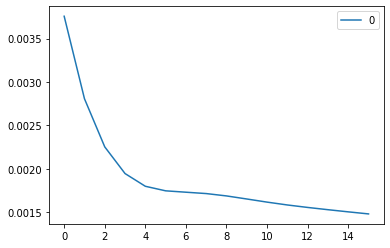

In [20]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [21]:
from scipy.spatial.distance import cosine

AnonymousSourcesIDList=[]

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(location_route_df)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('AnonymousSourcesID: ', location_route_df.iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('**********************************')
        AnonymousSourcesIDList.append(location_route_df.iloc[index, 0])

In [22]:
print('Top 5 Anomaly Instances when route changed:')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 5 Anomaly Instances when route changed:
AnonymousSourcesID:  32
Cosine Sim Val : -0.026944048702716827
**********************************
AnonymousSourcesID:  33
Cosine Sim Val : -0.026944048702716827
**********************************
AnonymousSourcesID:  34
Cosine Sim Val : -0.026944048702716827
**********************************
AnonymousSourcesID:  35
Cosine Sim Val : -0.026944048702716827
**********************************
AnonymousSourcesID:  36
Cosine Sim Val : -0.026944048702716827
**********************************


In [23]:
print("AnonymousSourcesIDs where anomaly detected: ",set(AnonymousSourcesIDList))

AnonymousSourcesIDs where anomaly detected:  {32, 33, 34, 35, 36}


Now we have anomaly events. we can get location details on the basis of AnonymousSourcesIDs.

In [24]:
rslt_df = df[df['AnonymousSources(MultipleNumbers)'].isin(AnonymousSourcesIDList)] 
rslt_df.head()

,AnonymousSources(MultipleNumbers),Date,LocationName,LocationFrom,LocationTo,AvgEstimatedArrivalInBeginning(mins),AvgActualArrivalTime(mins),RouteChanged,AlterRouteCords,MergedRouteCords
31,32,2020-11-27,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",44,90,Yes,"28.85685618521651, 77.10405884962915","28.841060922322438, 77.1272272579376"
32,33,2020-11-28,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",40,120,Yes,"28.85685618521651, 77.10405884962915","28.841060922322438, 77.1272272579376"
33,34,2020-11-29,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",40,110,Yes,"28.85685618521651, 77.10405884962915","28.841060922322438, 77.1272272579376"
34,35,2020-11-30,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",41,120,Yes,"28.85685618521651, 77.10405884962915","28.841060922322438, 77.1272272579376"
35,36,2020-12-01,Rai(Haryana) to Delhi via Sindhu border,"28.935280172368454, 77.10358897069602","28.704815223891988, 77.10195813669736",42,140,Yes,"28.85685618521651, 77.10405884962915","28.841060922322438, 77.1272272579376"


Now lets get the city, state, and country names by using latitude and longitude using the Geopy module. Geopy is easy package to locate the coordinates of addresses, cities, countries, and landmarks across the world.

In [25]:
# import module 
from geopy.geocoders import Nominatim
# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")
# Latitude & Longitude input 

def locationFinder(Latitude,Longitude):
 
    location = geolocator.reverse(str(28.841060922322438)+","+str(Longitude) )
    return str(location)




In [26]:
# Display 

#AlterRouteCords:

#28.85685618521651, 77.10405884962915

#MergedRouteCords
#28.841060922322438, 77.1272272579376

#Location for source where route changed:
location=locationFinder(28.85685618521651,77.10405884962915)
print(location)

#Location for destination where route merged back to original route:
location=locationFinder(28.85685618521651,77.1272272579376)
print(location)

Sector A-7, Narela Tehsil, North Delhi, Delhi, 110040, India
Alipur Tehsil, North Delhi, Delhi, 131028, India


Now lets try to capture news around these co-ordinates and date for AnonymousSourcesIDs having anomaly.

In [57]:
from GoogleNews import GoogleNews
googlenews = GoogleNews()

In [62]:
googlenews.set_lang('en')
googlenews.set_period('7d')
googlenews.set_time_range('11/27/2020','11/30/2020')
googlenews.set_encode('utf-8')


In [75]:
googlenews.get_texts()

['"Will Protest Till...": More Farmers Join Protesters At Delhi-UP Border',
 "Delhi Police Detain Two Journalists At Farmers' Protest Site In Singhu",
 '4-Storey Building Collapses In Delhi, None Hurt',
 'Delhi records maximum cold wave days in January in 13 years: IMD',
 "Delhi: Farmers' protest again gains momentum at Ghazipur, crowd swells up",
 'The many similarities between probes into the Delhi riots, R-Day violence',
 'Delhi Cong. wants Rahul to take over as party chief',
 'Delhi shifts stance, tweaks quarantine rules for UK flyers',
 'Leopard Spotted In Delhi, Forest Department Issues Alert',
 "Liquor manufacturers object to Delhi government's excise policy recommendations",
 'Delhi Police Case Against Shashi Tharoor, Others After UP, Madhya Pradesh',
 'Fuming over wife’s decision to visit parents, Delhi man shoots dead father-in-law',
 "GoM recommends 4G spectrum allocation to BSNL's Delhi and Mumbai circles",
 'Delhi likely to get two stations under three proposed Bullet trai

Now we can analyse this data using NLP, and search for any route closures or change due to some incidence happened and raise a flag. We can alert user in advance that there can be some unexpected delays or change in route can happened at specific location so that user can plan his travel really well. 

Analysing data is currently out of scope for this article, however please see below output highlighted by ALLEN NLP demo on our news data:

https://demo.allennlp.org/open-information-extraction/open-information-extraction

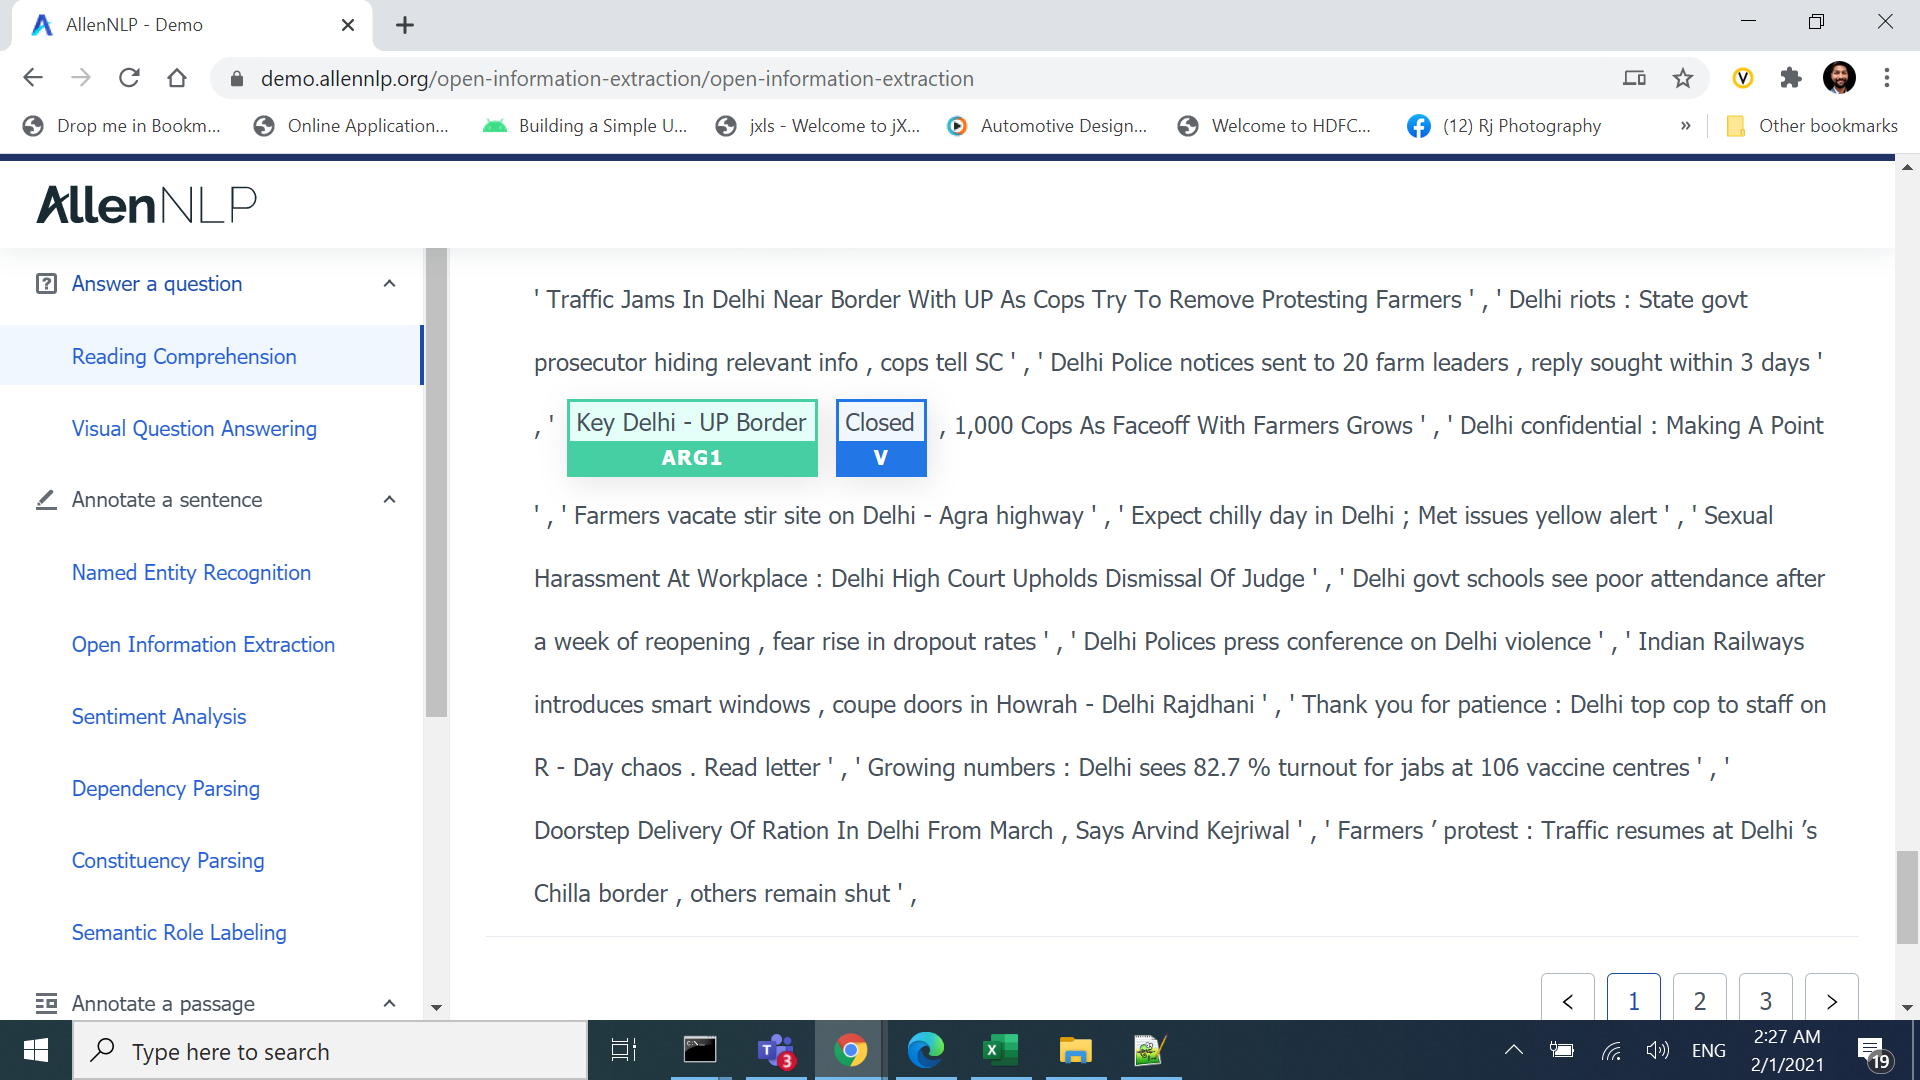